# Code to generate Frustration fouls and Euro Fouls

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from IPython.display import clear_output
from collections import Counter
from functools import reduce
import itertools
from nba_api.stats.static import teams
from pbpstats.client import Client
from tqdm import tqdm
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

In [3]:
from pbpstats.client import Client

settings = {
    "Games": {"source": "web", "data_provider": "data_nba"},
     "dir": "G:/My Drive/Sra_coding/NBA/pbpdata",
}
client = Client(settings)
# ID of all games for 2020-21 Season
league = "nba"
season_yr = "2020"
season_type = "Regular Season"
season = client.Season(league, season_yr, season_type)
games_id = []

for final_game in season.games.final_games:
    games_id.append(final_game['game_id'])
print(len(games_id))

1080


In [4]:
settings = {
    "Boxscore": {"source": "file", "data_provider": "data_nba"},
    "Possessions": {"source": "file", "data_provider": "data_nba"},
    "dir": "G:/My Drive/Sra_coding/NBA/pbpdata"
}
client = Client(settings)
games_list = []
bad_games_list = []
for gameid in tqdm(games_id):
    try:
        games_list.append(client.Game(gameid))
    except:
        # print(gameid)
        bad_games_list.append(gameid)
        continue
print(len(bad_games_list))

100%|██████████| 1080/1080 [00:58<00:00, 18.56it/s]

11


In [5]:
from pbpstats.resources.enhanced_pbp import Foul
from pbpstats.resources.enhanced_pbp import Turnover
from pbpstats.resources.enhanced_pbp import FieldGoal
pos_store = []
TO_Miss_pID = []
Foul_pID = []
Foul_tID = []
for game in tqdm(games_list):
    for possession in game.possessions.items:
        for possession_event in possession.events:
            if isinstance(possession_event, Foul) and (isinstance(possession_event.previous_event, Turnover) or  (isinstance(possession_event.previous_event, FieldGoal) and not possession_event.previous_event.is_made)) and possession_event.seconds_since_previous_event <= 5:
                pos_store.append(possession)
                TO_Miss_pID.append(possession_event.previous_event.player1_id)
                # print ("Turnover/Missed Shot Player: {0}".format(possession_event.previous_event.player1_id))
                Foul_pID.append(possession_event.player1_id)
                Foul_tID.append(possession_event.team_id)
                # print ("Foul Player: {0}".format(possession_event.player1_id))

100%|██████████| 1069/1069 [00:00<00:00, 3747.78it/s]


In [6]:
year = int(season_yr)
player_dict = get_players(league = 'NBA', from_year = year, to_year = year)
team_dict = teams.get_teams() # Creating Team Dictionary
team_id = [x['id'] for x in team_dict ]

In [7]:
Player_Name = []
a = Foul_pID
Foul_pID1, Fouls = np.unique(a, return_counts=True)  

for pID in Foul_pID1:
    Player_Name.append([player['Name'] for player in player_dict if player['pID'] == pID]) 

In [8]:

for i in range(len(Player_Name)):
    if not Player_Name[i]:
        Player_Name[i] =['abc']
Player_Name = list(itertools.chain(*Player_Name))
print(len(Player_Name))
print(len(Foul_pID1))

448
448


In [9]:
data_euroP = pd.DataFrame({'Foul_pID':Foul_pID1,'Player_Name':Player_Name,'Fouls':Fouls})
data_euroP = data_euroP[data_euroP['Player_Name'] != 'abc']
# data_euroP.to_csv ('Fast_Fouls_20_21_updated.csv',index=False)

In [10]:
Team_Name = [] 
a = Foul_tID
Foul_tID1, Fouls = np.unique(a, return_counts=True)  
for tID in Foul_tID1:  
    Team_Name.append([team['full_name'] for team in team_dict if team['id'] == tID])
Team_Name = list(itertools.chain(*Team_Name))

In [11]:
data_euroT = pd.DataFrame({'Foul_tID':Foul_tID1,'Team_Name':Team_Name,'Fouls':Fouls})
# data_euroT.to_csv ('Fast_Fouls_20_21_teams_updated.csv',index=False)

In [12]:
FFoul_pID =[]
k = 0
for i in range(len(TO_Miss_pID)):
    if TO_Miss_pID[i] == Foul_pID[i]:
        FFoul_pID.append(Foul_pID[i])
        k +=1
        print(k)
        clear_output(wait=True)

717


In [13]:
Player_Name = []
a = FFoul_pID
FFoul_pID, Fouls = np.unique(a, return_counts=True)
for pID in FFoul_pID:
    Player_Name.append([player['Name'] for player in player_dict if player['pID'] == pID]) 

In [14]:
for i in range(len(Player_Name)):
    if not Player_Name[i]:
        Player_Name[i] =['abc']
Player_Name = list(itertools.chain(*Player_Name))
print(len(Player_Name))
print(len(FFoul_pID))

275
275


In [15]:
data_frust = pd.DataFrame({'FFoul_pID':FFoul_pID,'Player':Player_Name,'Fouls':Fouls})
data_frust = data_frust[data_frust['Player'] != 'abc']
# data_frust.to_csv ('Frustration_Fouls_20_21_updated.csv',index=False)

In [16]:
data_frust['rank'] = data_frust['Fouls'].rank(ascending=False) 
data_frust = data_frust.sort_values(by=['rank'])
data_frust_plot = data_frust.drop(columns=['FFoul_pID', 'rank'])
data_frust_plot = data_frust_plot.head(10)
data_frust_plot

,Player,Fouls
4,Chris Paul,15
162,Donovan Mitchell,13
204,Luka Doncic,12
93,Zach LaVine,9
101,Julius Randle,9
107,Nikola Jokic,9
8,Kyle Lowry,9
17,Russell Westbrook,9
12,Mike Conley,8
202,Trae Young,8


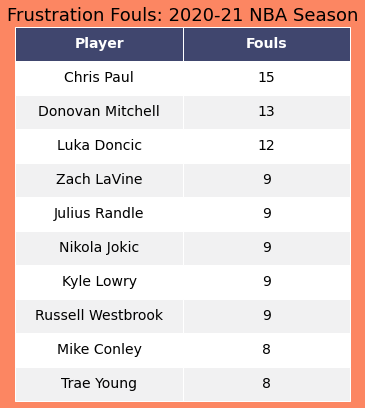

In [29]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox,cellLoc='center', colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    fig.set_facecolor('#fc8662')
    return ax.get_figure(), ax

fig,ax = render_mpl_table(data_frust_plot, header_columns=0, col_width=3.0)
ax.set_title(f"Frustration Fouls: 2020-21 NBA Season",fontsize=18)
# fig.tight_layout()
fig.savefig("frust_foul.png")